In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


___

In [3]:
import requests

def submit_to_mmseqs2_robust(seq):
    url = "https://a3m.mmseqs.com/ticket"
    # Ensure the data key is 'q' and the sequence is in FASTA format
    data = {"q": f">seq\n{seq}"}
    
    # 1. Execute the request
    response = requests.post(url, data=data)
    
    # 2. Check the status code for success (200 OK)
    if response.status_code == 200:
        # Request succeeded, now safely decode the JSON
        try:
            return response.json()
        except requests.exceptions.JSONDecodeError as e:
            # Handle cases where status is 200 but the body is still bad JSON
            print("Error: Received 200 OK, but failed to decode JSON.")
            print(f"Raw Response Text: {response.text[:200]}...") # Print first 200 chars
            raise e # Re-raise the error for the caller
    else:
        # Request failed (e.g., 400, 500). Print the error status and text.
        print(f"ERROR: MMseqs2 API returned status code {response.status_code}.")
        print(f"Server Error Message: {response.text}")
        return None # Return None or raise a custom exception

# Example of calling the robust function
result = submit_to_mmseqs2_robust("MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQ")
print("\nFinal Result:", result)

ERROR: MMseqs2 API returned status code 404.
Server Error Message: 404 page not found


Final Result: None


## Feature Engineering

+ Data Cleaning

In [126]:
df = pd.read_csv("../../data/raw/yahoo_BTC-USD_2020.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date").reset_index(drop=True)

for col in ["Close", "High", "Low", "Open", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
df = df.drop(columns=["Source", "Symbol"])
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Close   365 non-null    float64       
 2   High    365 non-null    float64       
 3   Low     365 non-null    float64       
 4   Open    365 non-null    float64       
 5   Volume  365 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 17.3 KB
None
        Date        Close         High          Low         Open        Volume
0 2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  1.856566e+10
1 2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  2.080208e+10
2 2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  2.811148e+10
3 2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  1.844427e+10
4 2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  1.972507e+10


+ Add technical Indicators data

In [127]:
def ema(series, span):
    """Exponential Moving Average (no leakage)."""
    return series.ewm(span=span, adjust=False).mean()

def wma(series, period):
    weights = np.arange(1, period +1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def hma(series, period):
    """Hull Moving Average."""
    half = int(period / 2)
    sqrt_n = int(np.sqrt(period))
    wma_half = wma(series, half)
    wma_full = wma(series, period)
    hma_ = wma(2 * wma_half - wma_full, sqrt_n)
    return hma_

def rsi(series, period=14):
    """Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain_ema = pd.Series(gain).ewm(span=period, adjust=False).mean()
    loss_ema = pd.Series(loss).ewm(span=period, adjust=False).mean()
    rs = gain_ema / (loss_ema + 1e-10)
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    """MACD line, Signal line, Histogram."""
    ema_fast = ema(series, fast)
    ema_slow = ema(series, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

In [128]:
df["EMA_34"]  = ema(df["Close"], 34)
df["EMA_89"]  = ema(df["Close"], 89)
df["EMA_200"] = ema(df["Close"], 200)
df["HMA_200"] = hma(df["Close"], 200)

df["RSI_14"] = rsi(df["Close"], 14)
macd_line, signal_line, hist = macd(df["Close"], fast=12, slow=26, signal=9)
df["MACD_Line"] = macd_line
df["MACD_Signal"] = signal_line
df["MACD_Hist"] = hist

# --- Volume-based features
df["Volume_Change"] = df["Volume"].pct_change()
df["Volume_EMA_34"] = ema(df["Volume"], 34)

df['OC_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100      # open-close change %
df['HL_Change'] = (df['High'] - df['Low']) / df['Low'] * 100         # high-low range %
df['OC_Change_perVol'] = df['OC_Change'] / (df['Volume'] + 1e-9)
df['HL_Change_perVol'] = df['HL_Change'] / (df['Volume'] + 1e-9)

print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              365 non-null    datetime64[ns]
 1   Close             365 non-null    float64       
 2   High              365 non-null    float64       
 3   Low               365 non-null    float64       
 4   Open              365 non-null    float64       
 5   Volume            365 non-null    float64       
 6   EMA_34            366 non-null    float64       
 7   EMA_89            366 non-null    float64       
 8   EMA_200           366 non-null    float64       
 9   HMA_200           153 non-null    float64       
 10  RSI_14            366 non-null    float64       
 11  MACD_Line         366 non-null    float64       
 12  MACD_Signal       366 non-null    float64       
 13  MACD_Hist         366 non-null    float64       
 14  Volume_Change     365 non-

C:\Users\windows\AppData\Local\Temp\ipykernel_34660\3993815827.py:13: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Volume_Change"] = df["Volume"].pct_change()


+ Normalization

In [129]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df['Return'] = df['Close'].pct_change()                         #.shift(-1)  # Next day's return
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))   #.shift(-1)  # Next day's log return

#Add lag
for lag in [1, 3, 5]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)

window = 14
df['Rolling_Mean_14'] = df['Close'].rolling(window).mean()
df['Rolling_Std_14'] = df['Close'].rolling(window).std()

# ATR - Average True Range
high = df['High']
low = df['Low']
close = df['Close']

df['Prev_Close'] = close.shift(1)
df['TR'] = np.maximum.reduce([
    high - low,
    abs(high - df['Prev_Close']),
    abs(low - df['Prev_Close'])
])
df['ATR_14'] = df['TR'].rolling(window=14).mean()
                                                            
# Normalization and Scaling
#scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns
scaled_cols = numeric_cols.difference(['Date'])  # exclude Date
df_scaled = df.copy()
#df_scaled[scaled_cols] = scaler.fit_transform(df_scaled[scaled_cols])

C:\Users\windows\AppData\Local\Temp\ipykernel_34660\3930522409.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()                         #.shift(-1)  # Next day's return


In [144]:
df_scaled.head(5)

,Close,High,Low,Open,Volume,EMA_34,EMA_89,EMA_200,HMA_200,RSI_14,...,Close_Lag_3,Return_Lag_3,Close_Lag_5,Return_Lag_5,Rolling_Mean_14,Rolling_Std_14,Prev_Close,TR,ATR_14,Target
0,11323.466797,11415.864258,10987.053711,11110.210938,2.316047e+10,9798.340417,9306.007198,8740.458297,9960.194697,92.243676,...,10912.823242,-0.007101,9905.166992,0.023566,10039.173549,840.277482,11111.213867,428.810547,336.483538,0.037792
1,11759.592773,11794.775391,11239.682617,11322.570312,2.607567e+10,9910.411980,9360.531322,8770.499436,9999.787108,94.299245,...,11100.467773,0.017195,10990.873047,0.109610,10224.927316,914.877295,11323.466797,555.092773,366.835938,-0.061912
2,11053.614258,12034.144531,11018.129883,11758.764648,2.741007e+10,9975.737825,9398.155387,8793.216996,10041.354007,63.076497,...,11111.213867,0.000968,10912.823242,-0.007101,10358.341378,887.467801,11759.592773,1016.014648,431.996582,0.017286
3,11246.348633,11453.079102,11012.415039,11043.768555,2.027171e+10,10048.344157,9439.226348,8817.626266,10085.114300,66.563842,...,11323.466797,0.019103,11100.467773,0.017195,10507.064035,845.430643,11053.614258,440.664062,457.989676,-0.003604
4,11205.892578,11385.381836,11094.145508,11246.203125,2.125020e+10,10114.489781,9478.485598,8841.390110,10130.301367,65.075235,...,11759.592773,0.038515,11111.213867,0.000968,10637.850098,797.055002,11246.348633,291.236328,460.372768,0.047160


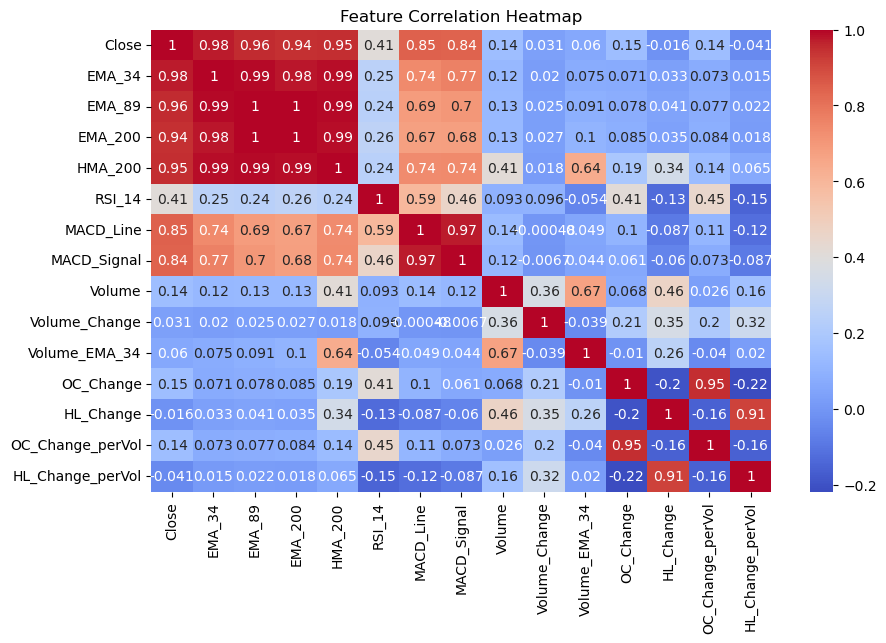

In [130]:
# Quick correlation heatmap
corr = df_scaled[["Close", "EMA_34", "EMA_89", "EMA_200", "HMA_200", "RSI_14", "MACD_Line", "MACD_Signal","Volume", "Volume_Change", "Volume_EMA_34", "OC_Change", "HL_Change", "OC_Change_perVol", "HL_Change_perVol"]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [131]:
print(df.info())
df = df[scaled_cols]
df.to_csv("../../data/processed/yahoo_BTC-USD_2020.csv", index=False)
df_scaled.to_csv("../../data/processed/yahoo_BTC-USD_2020_processed.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              365 non-null    datetime64[ns]
 1   Close             365 non-null    float64       
 2   High              365 non-null    float64       
 3   Low               365 non-null    float64       
 4   Open              365 non-null    float64       
 5   Volume            365 non-null    float64       
 6   EMA_34            366 non-null    float64       
 7   EMA_89            366 non-null    float64       
 8   EMA_200           366 non-null    float64       
 9   HMA_200           153 non-null    float64       
 10  RSI_14            366 non-null    float64       
 11  MACD_Line         366 non-null    float64       
 12  MACD_Signal       366 non-null    float64       
 13  MACD_Hist         366 non-null    float64       
 14  Volume_Change     365 non-

___

# Slidinng window and Train-Test split

In [132]:
from sklearn.model_selection import train_test_split

df_scaled = df_scaled.select_dtypes(include=[np.number]).dropna().reset_index(drop=True)
ddf_scaledf = df_scaled.fillna(method='bfill').fillna(method='ffill')

exclude_cols = ["Date", "Close", 'Return', 'Log_Return']
feature_cols = [c for c in df.columns if c not in exclude_cols]

#Choose Target
df_scaled["Target"] = df_scaled["Log_Return"].shift(-1)
df_scaled = df_scaled.dropna(subset = ["Target"])

# Create sliding window
def create_sliding_window(df, feature_cols, target_col, seq_len = 60):
    X, y = [], []
    data = df[feature_cols].values
    target = df[target_col].values

    for i in range(len(df) - seq_len):
        X.append(data[i:i+seq_len])                 # 60-day sequence
        y.append(target[i+seq_len])                 # next-day target
    return np.array(X), np.array(y)

SEQ_LEN = 60
X , y= create_sliding_window(df_scaled, feature_cols, "Target", seq_len=SEQ_LEN)
print(X.shape,y.shape)
print(X)

(92, 60, 29) (92,)
[[[ 3.36483538e+02  1.11112139e+04  1.09128232e+04 ...  2.31604698e+10
    1.32658956e-02  1.98756623e+10]
  [ 3.66835938e+02  1.13234668e+04  1.11004678e+04 ...  2.60756703e+10
    1.25869664e-01  2.02299485e+10]
  [ 4.31996582e+02  1.17595928e+04  1.11112139e+04 ...  2.74100673e+10
    5.11740261e-02  2.06402410e+10]
  ...
  [ 3.22590332e+02  1.06927168e+04  1.02461865e+04 ...  4.68525255e+10
    1.90704022e-01  3.14645304e+10]
  [ 3.10316755e+02  1.07507236e+04  1.07600664e+04 ...  5.37459728e+10
    1.47130752e-01  3.27377556e+10]
  [ 2.89420480e+02  1.07752695e+04  1.06927168e+04 ...  4.77623947e+10
   -1.11330724e-01  3.35963065e+10]]

 [[ 3.66835938e+02  1.13234668e+04  1.11004678e+04 ...  2.60756703e+10
    1.25869664e-01  2.02299485e+10]
  [ 4.31996582e+02  1.17595928e+04  1.11112139e+04 ...  2.74100673e+10
    5.11740261e-02  2.06402410e+10]
  [ 4.57989676e+02  1.10536143e+04  1.13234668e+04 ...  2.02717134e+10
   -2.60428178e-01  2.06191823e+10]
  ...
  [ 

C:\Users\windows\AppData\Local\Temp\ipykernel_34660\1796337589.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ddf_scaledf = df_scaled.fillna(method='bfill').fillna(method='ffill')


+ Split train and test dataset

In [133]:
train_size = int(0.7*len(X))
validation_size = int(0.9*len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:validation_size], y[train_size:validation_size]
X_test, y_test = X[validation_size:], y[validation_size:]

print(train_size, validation_size, len(X))
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape) 
print(X_test.shape, y_test.shape)

np.savez_compressed("../../data/processed/processed_timeseries.npz",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test)


64 82 92
(64, 60, 29) (64,)
(18, 60, 29) (18,)
(10, 60, 29) (10,)


In [134]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = TimeSeriesDataset(X_train, y_train)
val_data   = TimeSeriesDataset(X_val, y_val)
test_data  = TimeSeriesDataset(X_test, y_test)


## Model development

In [135]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [136]:
# CNN + LSTM
class CNNLSTM(nn.Module):
    def __init__(self, n_features, cnn_channels = 32, kernel_size = 3, lstm_hidden = 64, lstm_layers =1, fc_hidden=32, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=cnn_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, 1)
        )
    def forward(self, x):
        x = x.transpose(1,2) 
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.transpose(1,2)
        out, (h,c) = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

In [137]:
class LSTMOnly(nn.Module):
    def __init__(self, n_features, lstm_hidden=64, lstm_layers=2, fc_hidden=32, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, 1)
            )
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)
        

In [138]:
class CNNOnly(nn.Module):
    def __init__(self, n_features, cnn_channels=64, kernel_size = 3, fc_hidden= 64, dropout=0.1 ):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=cnn_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(cnn_channels, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, 1)
        )
    def forward(self, x):
        x = x.transpose(1,2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1) 
        return self.fc(x)

## Metric Evaluation

In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import deepcopy
import json
import os

In [140]:
def directional_accuracy(y_true, y_pred):
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    return np.mean(np.sign(yt) == np.sign(yp))

In [141]:
def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    losses = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return float(np.mean(losses))

def evaluate(model, loader, loss_fn, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds.append(out)
            trues.append(yb.numpy())
    preds = np.vstack(preds).reshape(-1,1)
    trues = np.vstack(trues).reshape(-1,1)
    loss = loss_fn(torch.tensor(preds), torch.tensor(trues)).item()
    return preds.reshape(-1), trues.reshape(-1), loss

In [142]:
def run_grid_search(X_train, y_train, X_val, y_val, model_choices, param_grid, budget_epochs=10, batch_size=64):
    """
    Simple grid search: iterate model_choices & param_grid and train for budget_epochs,
    return a summary dict with validation loss and metrics.
    """
    results = []
    train_ds = TimeSeriesDataset(X_train, y_train)
    val_ds = TimeSeriesDataset(X_val, y_val)

    for model_name in model_choices:
        for params in param_grid:
            # Build model object depending on model_name
            if model_name == "CNNLSTM":
                model = CNNLSTM(n_features=X_train.shape[2],
                                cnn_channels=params.get("cnn_channels",32),
                                kernel_size=params.get("kernel_size",3),
                                lstm_hidden=params.get("lstm_hidden",64),
                                lstm_layers=params.get("lstm_layers",1),
                                fc_hidden=params.get("fc_hidden",32),
                                dropout=params.get("dropout",0.1))
            elif model_name == "LSTM":
                model = LSTMOnly(n_features=X_train.shape[2],
                                 lstm_hidden=params.get("lstm_hidden",64),
                                 lstm_layers=params.get("lstm_layers",1),
                                 fc_hidden=params.get("fc_hidden",32),
                                 dropout=params.get("dropout",0.1))
            elif model_name == "CNN":
                model = CNNOnly(n_features=X_train.shape[2],
                                cnn_channels=params.get("cnn_channels",32),
                                kernel_size=params.get("kernel_size",3),
                                fc_hidden=params.get("fc_hidden",32),
                                dropout=params.get("dropout",0.1))
            else:
                raise ValueError("Unknown model")

            model = model.to(DEVICE)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
            val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

            opt = torch.optim.Adam(model.parameters(), lr=params.get("lr",1e-3), weight_decay=params.get("wd",0.0))
            loss_fn = nn.MSELoss()
            best_val = 1e9
            best_state = None
            for epoch in range(budget_epochs):
                tr_loss = train_one_epoch(model, train_loader, opt, loss_fn, DEVICE)
                preds_val, trues_val, val_loss = evaluate(model, val_loader, loss_fn, DEVICE)
                if val_loss < best_val:
                    best_val = val_loss
                    best_state = deepcopy(model.state_dict())
            # compute directional accuracy and MAE for reporting
            da = directional_accuracy(trues_val, preds_val)
            mae = mean_absolute_error(trues_val, preds_val)
            mse = mean_squared_error(trues_val, preds_val)
            results.append({
                "model": model_name,
                "params": params,
                "val_mse": float(mse),
                "val_mae": float(mae),
                "val_loss": float(best_val),
                "directional_acc": float(da)
            })
            print(f"Grid result: {model_name} {params} -> val_mse={mse:.6f} mae={mae:.6f} da={da:.3f}")
    return results


Shapes: (64, 60, 29) (64,) (18, 60, 29) (10, 60, 29)


Grid result: CNNLSTM {'lr': 0.001, 'cnn_channels': 32, 'lstm_hidden': 64, 'lstm_layers': 1, 'fc_hidden': 32, 'dropout': 0.1} -> val_mse=0.002542 mae=0.038444 da=0.611
Grid result: CNNLSTM {'lr': 0.0003, 'cnn_channels': 64, 'lstm_hidden': 128, 'lstm_layers': 1, 'fc_hidden': 64, 'dropout': 0.2} -> val_mse=0.018104 mae=0.128936 da=0.333
Grid result: LSTM {'lr': 0.001, 'cnn_channels': 32, 'lstm_hidden': 64, 'lstm_layers': 1, 'fc_hidden': 32, 'dropout': 0.1} -> val_mse=0.002193 mae=0.035902 da=0.389
Grid result: LSTM {'lr': 0.0003, 'cnn_channels': 64, 'lstm_hidden': 128, 'lstm_layers': 1, 'fc_hidden': 64, 'dropout': 0.2} -> val_mse=0.001950 mae=0.038393 da=0.333
Grid result: CNN {'lr': 0.001, 'cnn_channels': 32, 'lstm_hidden': 64, 'lstm_layers': 1, 'fc_hidden': 32, 'dropout': 0.1} -> val_mse=16258516910080.000000 mae=3930284.000000 da=0.667
Grid result: CNN {'lr': 0.0003, 'cnn_channels': 64, 'lstm_hidden': 128, 'lstm_layers': 1, 'fc_hidden': 64, 'dropout': 0.2} -> val_mse=1228258641182720.0

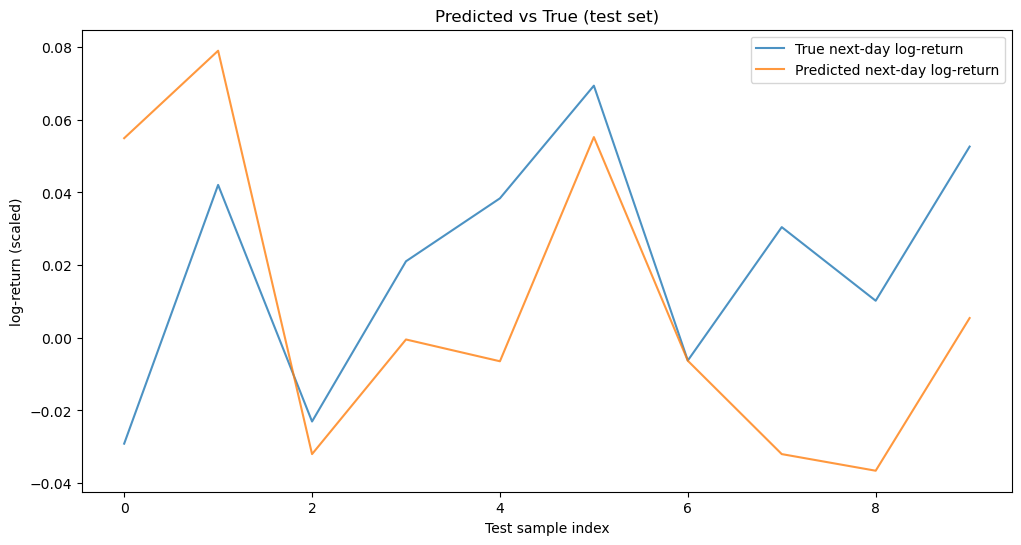

Saved train_summary.json


In [143]:
# -------------------------
# Main: load data, run grid, train best, visualize
# -------------------------
def main():
    # Load data
    data = np.load("../../data/processed/processed_timeseries.npz")
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_val   = data["X_val"]
    y_val   = data["y_val"]
    X_test  = data["X_test"]
    y_test  = data["y_test"]
    print("Shapes:", X_train.shape, y_train.shape, X_val.shape, X_test.shape)

    # quick sanity: ensure 3D tensors
    assert X_train.ndim == 3

    # small hyperparameter grid (expand as needed)
    model_choices = ["CNNLSTM", "LSTM", "CNN"]
    param_grid = [
        {"lr": 1e-3, "cnn_channels": 32, "lstm_hidden": 64, "lstm_layers": 1, "fc_hidden": 32, "dropout":0.1},
        {"lr": 3e-4, "cnn_channels": 64, "lstm_hidden": 128, "lstm_layers": 1, "fc_hidden": 64, "dropout":0.2},
    ]

    grid_results = run_grid_search(X_train, y_train, X_val, y_val, model_choices, param_grid, budget_epochs=6, batch_size=64)

    # Sort by val_mse
    grid_results = sorted(grid_results, key=lambda r: r["val_mse"])
    print("Top results:", grid_results[:3])
    # pick best
    best = grid_results[0]
    print("Chosen best:", best)

    # Build best model and train longer
    best_params = best["params"]
    if best["model"] == "CNNLSTM":
        model = CNNLSTM(n_features=X_train.shape[2],
                        cnn_channels=best_params.get("cnn_channels",32),
                        kernel_size=best_params.get("kernel_size",3),
                        lstm_hidden=best_params.get("lstm_hidden",64),
                        lstm_layers=best_params.get("lstm_layers",1),
                        fc_hidden=best_params.get("fc_hidden",32),
                        dropout=best_params.get("dropout",0.1))
    elif best["model"] == "LSTM":
        model = LSTMOnly(n_features=X_train.shape[2],
                         lstm_hidden=best_params.get("lstm_hidden",64),
                         lstm_layers=best_params.get("lstm_layers",1),
                         fc_hidden=best_params.get("fc_hidden",32),
                         dropout=best_params.get("dropout",0.1))
    else:
        model = CNNOnly(n_features=X_train.shape[2],
                        cnn_channels=best_params.get("cnn_channels",32),
                        kernel_size=best_params.get("kernel_size",3),
                        fc_hidden=best_params.get("fc_hidden",32),
                        dropout=best_params.get("dropout",0.1))

    model = model.to(DEVICE)
    train_ds = TimeSeriesDataset(X_train, y_train)
    val_ds   = TimeSeriesDataset(X_val, y_val)
    test_ds  = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
    test_loader= DataLoader(test_ds, batch_size=128, shuffle=False)

    opt = torch.optim.Adam(model.parameters(), lr=best_params.get("lr",1e-3))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5)
    loss_fn = nn.MSELoss()
    best_val = 1e9
    patience=10
    wait=0
    ckpt_dir = "checkpoints"
    os.makedirs(ckpt_dir, exist_ok=True)

    EPOCHS = 60
    for epoch in range(1, EPOCHS+1):
        tr_loss = train_one_epoch(model, train_loader, opt, loss_fn, DEVICE)
        preds_val, trues_val, val_loss = evaluate(model, val_loader, loss_fn, DEVICE)
        scheduler.step(val_loss)
        print(f"[Epoch {epoch}] train_loss={tr_loss:.6f} val_loss={val_loss:.6f}")
        if val_loss < best_val:
            best_val = val_loss
            wait = 0
            torch.save({
                "model_state": model.state_dict(),
                "params": best_params
            }, os.path.join(ckpt_dir, "best_model.pt"))
            print("Saved best model.")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    ck = torch.load(os.path.join(ckpt_dir, "best_model.pt"), map_location=DEVICE)
    model.load_state_dict(ck["model_state"])

    # Evaluate on test set
    preds_test, trues_test, test_loss = evaluate(model, test_loader, loss_fn, DEVICE)
    mse = mean_squared_error(trues_test, preds_test)
    mae = mean_absolute_error(trues_test, preds_test)
    da = directional_accuracy(trues_test, preds_test)
    print("Test MSE:", mse, "MAE:", mae, "Directional Acc:", da)

    # Financial metrics: need close prices aligned; load original processed CSV that contains Close values
    # We'll assume a helper file 'processed_features.csv' exists with Date and Close
    df_proc = None
    if os.path.exists("processed_features.csv"):
        df_proc = pd.read_csv("processed_features.csv")
        df_proc = df_proc.sort_values("Date").reset_index(drop=True)
    else:
        print("Warning: processed_features.csv not found. Financial backtest will be approximate using cumulative returns in y_test.")

    # If df_proc exists, align values: we need close prices for the part corresponding to test set.
    if df_proc is not None:
        # Determine index mapping: we created sliding windows with seq_len and dropped last rows with NaN targets.
        seq_len = X_train.shape[1]  # assume same seq_len
        # Rebuild X and index mapping to find start index of test sample in original df
        # For simplicity we will assume test windows correspond to the last len(y_test) rows in df_proc after dropping NaNs.
        close_arr = df_proc['Close'].values
        # We'll pass close array of length len(preds_test)+1 (need next-day returns)

    # Plot predictions vs ground truth (test sample indices)
    plt.figure(figsize=(12,6))
    plt.plot(trues_test, label="True next-day log-return", alpha=0.8)
    plt.plot(preds_test, label="Predicted next-day log-return", alpha=0.8)
    plt.legend()
    plt.title("Predicted vs True (test set)")
    plt.xlabel("Test sample index")
    plt.ylabel("log-return (scaled)")
    plt.show()

    # Save final metrics to file
    summary = {
        "test_mse": mse,
        "test_mae": mae,
        "directional_acc": da,
        "best_grid": best
    }
    with open("train_summary.json","w") as f:
        json.dump(summary, f, indent=2)
    print("Saved train_summary.json")

#if __name__ == "__main__":
main()